### Let's look at the plots

In [1]:
# Import stuff
import numpy as np  
from NRT_functions import plotters
from NRT_functions import helper_functions
from NRT_functions import losses
#from NRT_functions import cell_analysis
from matplotlib import animation, rc
import jax.nn as nn
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Run this cell to reload the NRT_functions if there have been changes
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def convert_positions(phi):
    ptsnew = np.zeros([3, np.size(phi,1)])
    XY = np.cos(phi[0,:])
    ptsnew[0,:] = np.cos(phi[0,:])*np.cos(phi[1,:])
    ptsnew[1,:] = np.cos(phi[0,:])*np.sin(phi[1,:])
    ptsnew[2,:] = np.sin(phi[0,:])
    return ptsnew

In [4]:
%cd '/Users/will/Documents/Neural_Rep_Theory/ICLR_Actionable_Reps'

/Users/will/Documents/Neural_Rep_Theory/ICLR_Actionable_Reps


In [60]:
### Choose which weight vector to reload using the date (YYMMDD format) and time (HHMM) of the simulation, and the counter which just indexes each different run
day = '231109'
time = "182416"#"191526"
#time = "201316"
counter = 0
to_save = 1 # Wheher or not to save the figures

# Choose some plotting parameters
N_plot = 2000 # Number of angles for the plot
xyz = np.random.normal(size = [3,N_plot])
xyz = xyz/np.linalg.norm(xyz, axis = 0)[np.newaxis, :]
phi = helper_functions.convert_angles(xyz)

# Load up the weight matrix etc.
dots = 0
filepath = f"./data/{day}/{time}/"
parameters = helper_functions.load_obj("parameters", filepath)
RowsD = 3#np.sqrt(parameters["D"]) # Number of rows of neurons
W = helper_functions.load_obj(f"W_{counter}", filepath)
W_init = helper_functions.load_obj(f"W_init_{counter}", filepath)
Losses = helper_functions.load_obj(f"L_{counter}", filepath)
min_L = helper_functions.load_obj(f"min_L_{counter}", filepath)
ColumnsD = int(np.ceil(parameters["D"]/RowsD))
print(parameters["sigma_theta"])

# Create the neural functions to plot
phi_plot = np.linspace(0, 2*np.pi, N_plot)# Angle inputs
I_plot = helper_functions.initialise_irreps_sphere(parameters["ell_max"], phi)
V = np.matmul(W, I_plot)
V_init = np.matmul(W_init, I_plot)

0.1


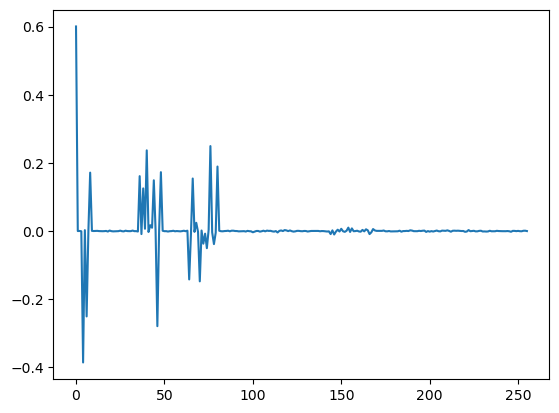

In [61]:
plt.plot(W[30,:])

In [62]:
parameters

{'D': 49,
 'T': 500000,
 'K': 1,
 'N_rand': 75,
 'N_shift': 4,
 'ell_max': 15,
 'resample_iters': 12,
 'lambda_pos_init': 0.5,
 'k_p': -9,
 'alpha_p': 0.9,
 'gamma_p': 0.0001,
 'lambda_equi_init': 0.5,
 'k_eq': -9,
 'alpha_eq': 0.9,
 'gamma_eq': 0.0001,
 'beta1': 0.9,
 'beta2': 0.9,
 'eta': 1e-08,
 'epsilon': 0.01,
 'random_seed': 34,
 'sigma_sq': 1,
 'sigma_theta': 0.1,
 'sep_loss_choice': 3}

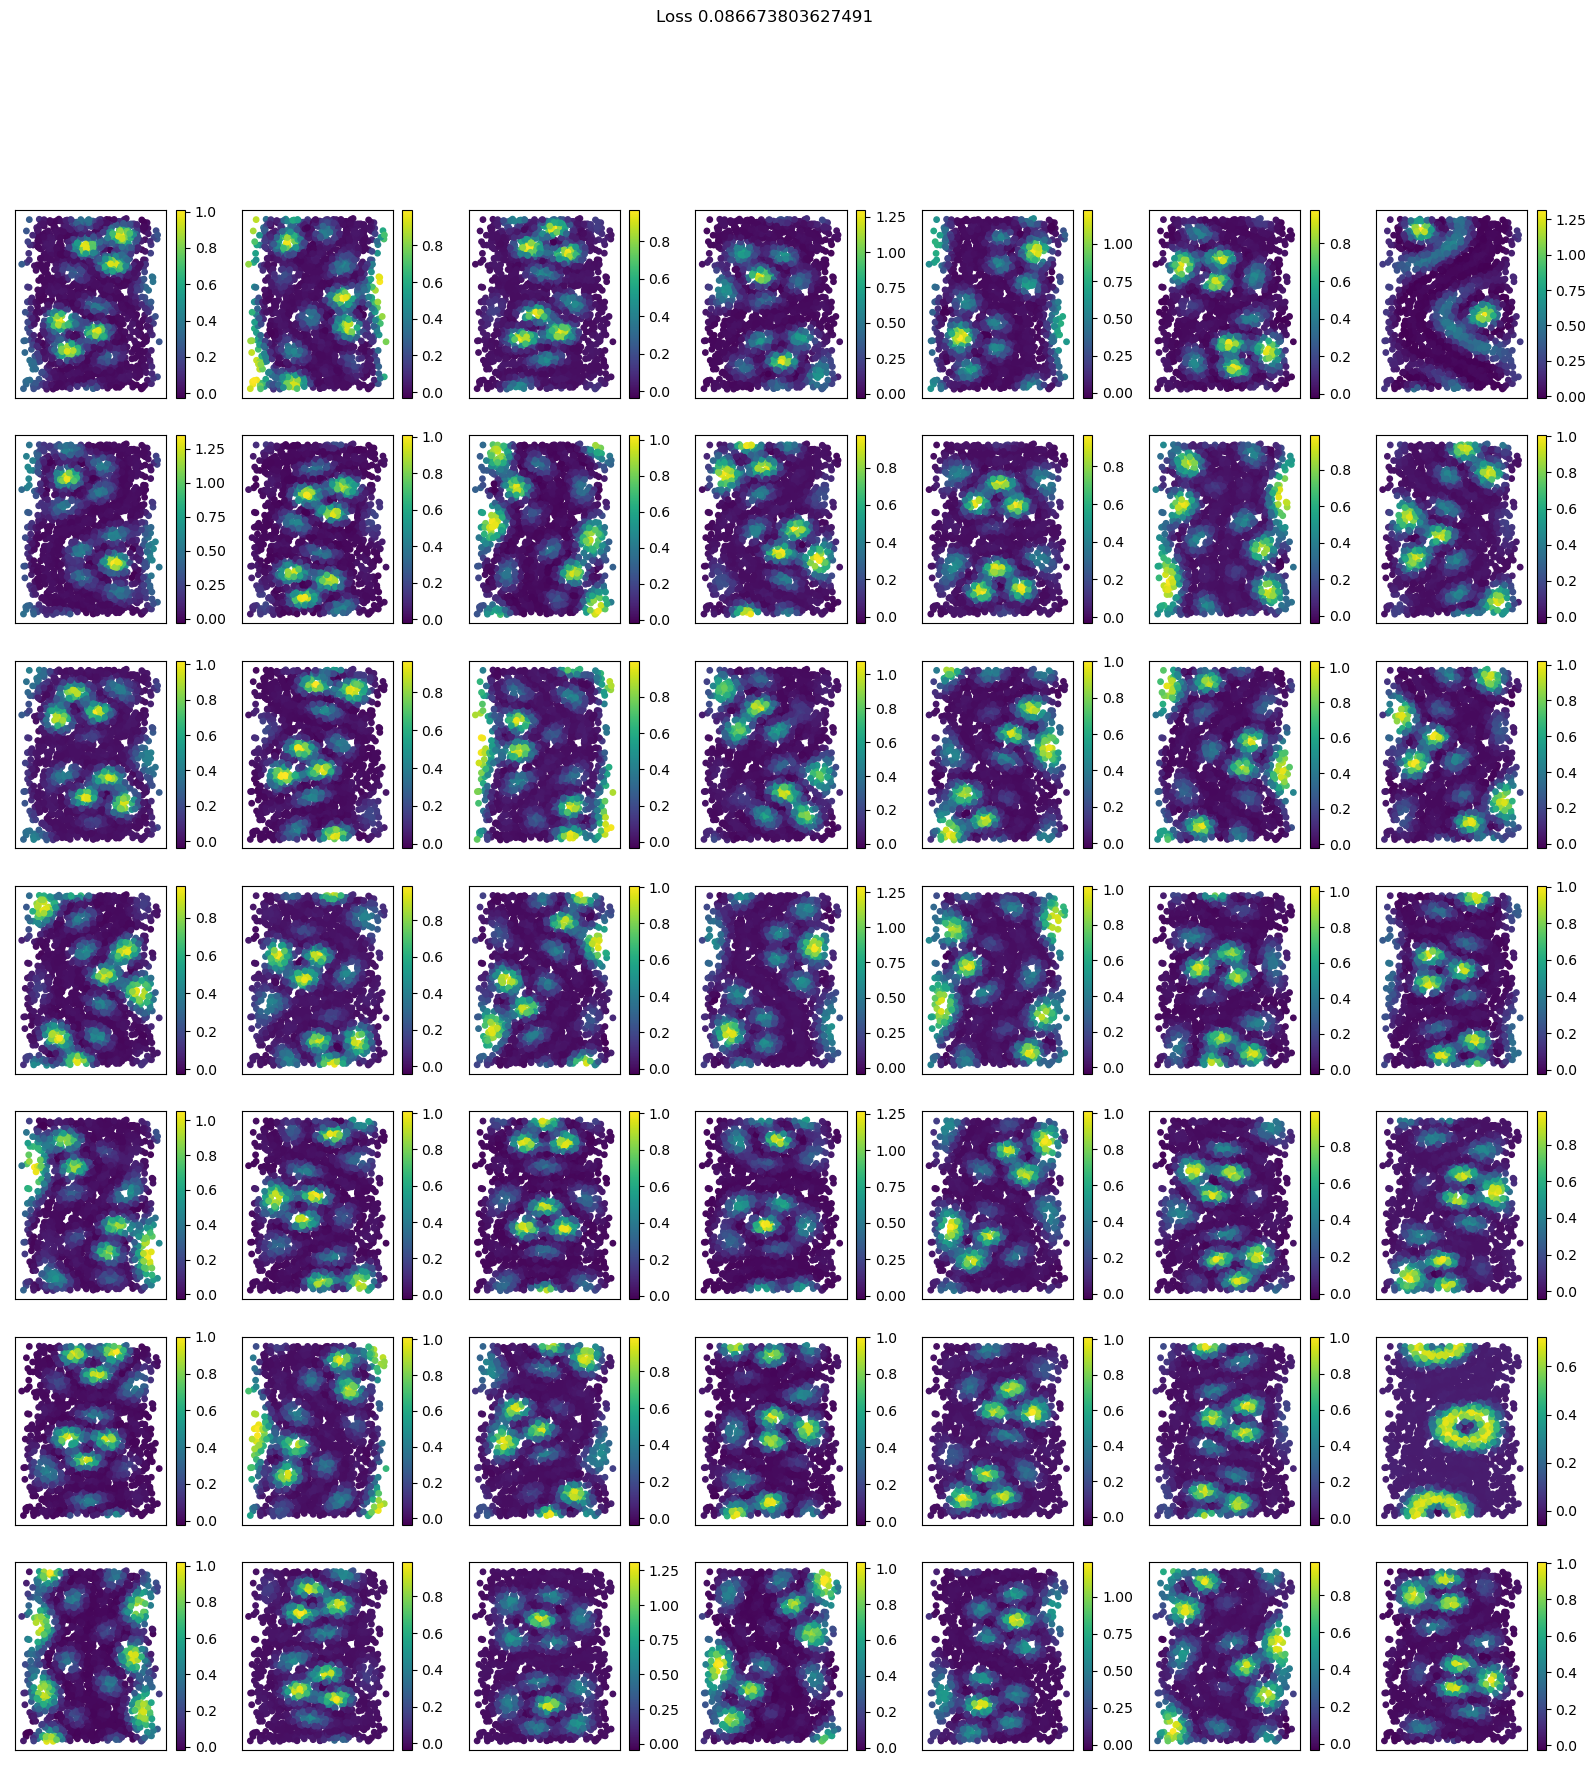

In [63]:
plt.figure(figsize = (20, 20))
plt.suptitle(f'Loss {min_L[1]}')
for n in range(49):
    plt.subplot(7,7,n+1)
    plt.scatter(phi[0,:], phi[1,:], c = V[n,:], s = 15)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
plt.savefig(f'{filepath}rate_map.pdf')

In [12]:
# Let's plot the initial response on the sphere
neuron = 0
V_colour = V[neuron,:]
V_colour[V_colour>0.1] = np.power(V_colour[V_colour > 0.1], 0.4)

fig = plt.figure(figsize = (12, 4))
subplots = ['251', '252', '253','254','255','256','257','258','259']
for neuron in range(9):
    ax = fig.add_subplot(subplots[neuron], projection='3d')
    ax.scatter(xyz[0,:], xyz[1,:], xyz[2,:], c = V[neuron,:], marker='o', s = 10)
if to_save:
    plotters.saveFigure(fig, day, time, "Final_Resp_Sphere")
    
fig = plt.figure(figsize = (12, 4))
for neuron in range(9):
    ax = fig.add_subplot(subplots[neuron], projection='3d')
    ax.scatter(xyz[0,:], xyz[1,:], xyz[2,:], c = V_init[neuron,:], marker='o', s = 10)
    
if to_save:
    plotters.saveFigure(fig, day, time, "Init_Resp_Sphere")

ValueError: Single argument to subplot must be a three-digit integer, not '251'

<Figure size 1200x400 with 0 Axes>

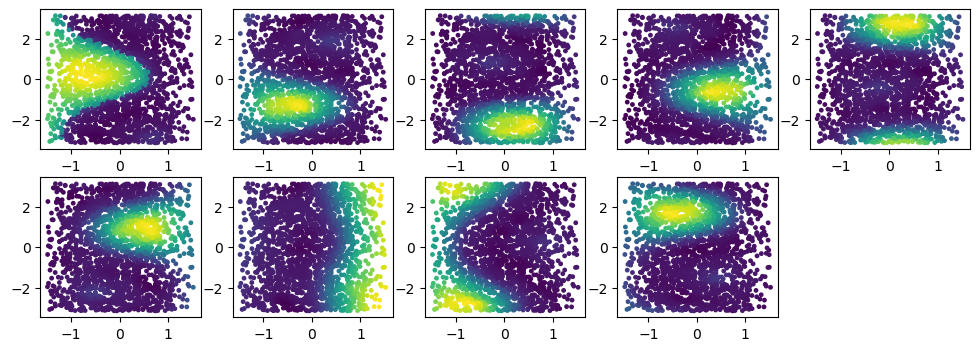

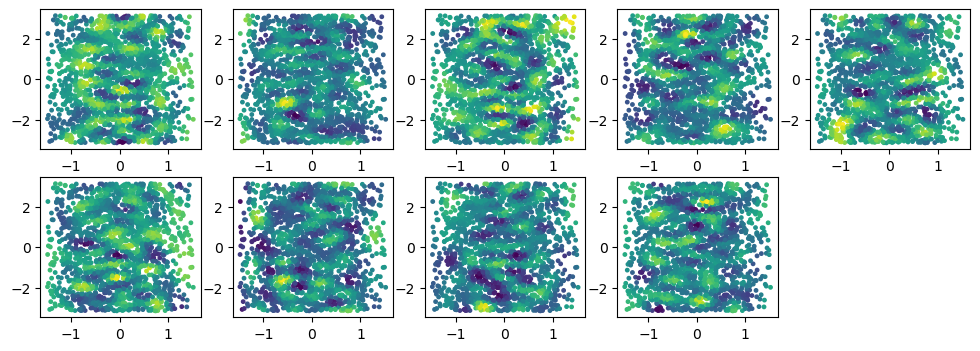

In [35]:
# And now just on the plane
fig = plt.figure(figsize = (12, 4))
for neuron in range(9):
    plt.subplot(2,5,neuron+1)
    plt.scatter(phi[0,:], phi[1,:], c = V[neuron,:],s=6)
if to_save:
    plotters.saveFigure(fig, day, time, "Final_Resp_Flat")

fig = plt.figure(figsize = (12, 4))
for neuron in range(9):
    plt.subplot(2,5,neuron+1)
    plt.scatter(phi[0,:], phi[1,:], c = V_init[neuron,:],s=6)
if to_save:
    plotters.saveFigure(fig, day, time, "Init_Resp_Flat")

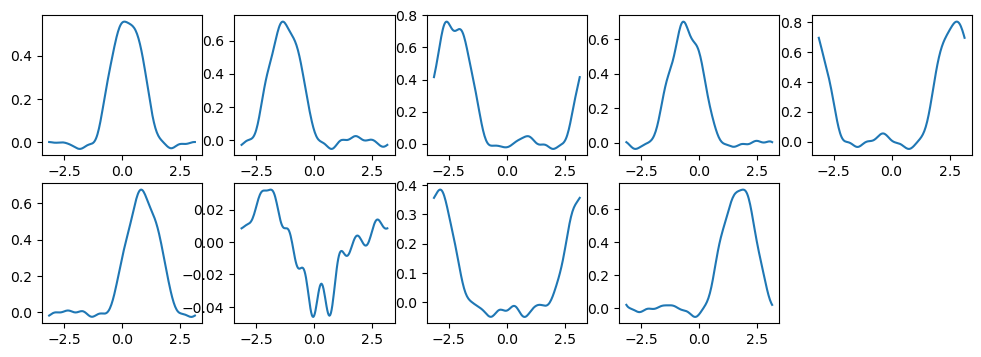

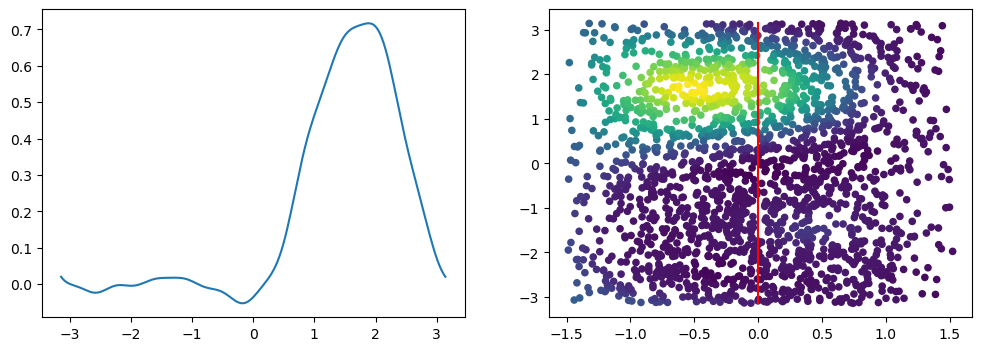

In [36]:
# Now time to try and sample some points of interest
points_num = 200
phi_special = np.zeros([2,points_num])
phi_special[0,:] = 0*np.linspace(-np.pi/2, np.pi/2, points_num)
phi_special[1,:] = np.linspace(-np.pi, np.pi, points_num)

xyz_special = convert_positions(phi_special)
rand_rotations = Rot.random(1).as_matrix()
xyz_spec_rot = np.matmul(rand_rotations, xyz_special)
phi_spec = helper_functions.convert_angles(xyz_spec_rot[0,:,:])

I_spec = helper_functions.initialise_irreps_sphere(parameters["M"], phi_special)
V_spec = np.matmul(W, I_spec)

fig = plt.figure(figsize = (12, 4))
for neuron in range(9):
    plt.subplot(2,5,neuron+1)
    plt.plot(phi_special[1,:], V_spec[neuron,:])
#plotters.saveFigure(fig, day, time, "Final_Resp_Flat")

fig = plt.figure(figsize = (12, 4))
neuron = 8
plt.subplot(1,2,1)
plt.plot(phi_special[1,:], V_spec[neuron,:])

plt.subplot(1,2,2)
plt.scatter(phi[0,:], phi[1,:], c = V[neuron,:],s=20)
plt.plot(phi_special[0,:],phi_special[1,:],c='r')

if to_save:
    plotters.saveFigure(fig, day, time, "Slice")

/Users/will/opt/anaconda3/envs/neural_rep_theo/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/Users/will/opt/anaconda3/envs/neural_rep_theo/lib/python3.10/site-packages/jax/_src/ops/scatter.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


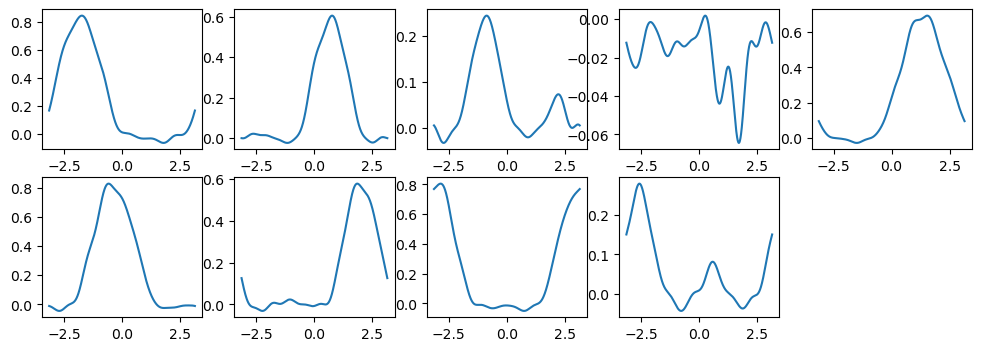

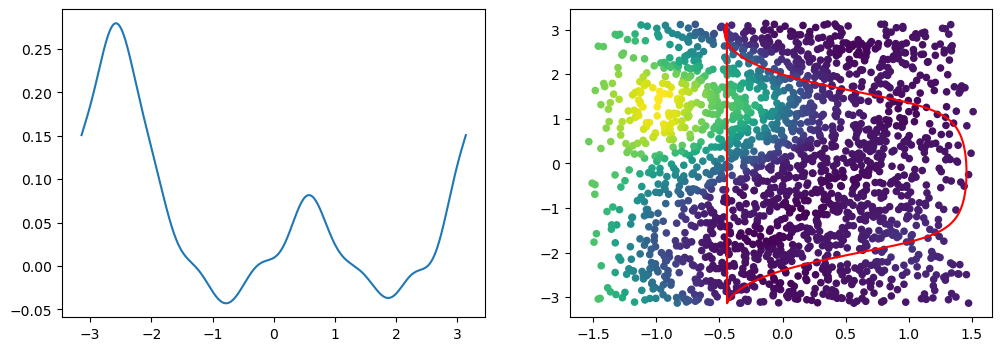

In [22]:
# Now time to try and sample some points of interest
points_num = 1000
phi_special = np.zeros([2,points_num])
phi_special[0,:] = 0.5*np.ones([1,points_num])
phi_special[1,:] = np.linspace(-np.pi, np.pi, points_num)

xyz_special = convert_positions(phi_special)
#rand_rotations = Rot.random(1).as_matrix()
xyz_spec_rot = np.matmul(rand_rotations, xyz_special)
phi_spec = helper_functions.convert_angles(xyz_spec_rot[0,:,:])

I_spec = helper_functions.initialise_irreps_sphere(parameters["M"], phi_spec)
V_spec = np.matmul(W, I_spec)

fig = plt.figure(figsize = (12, 4))
for neuron in range(9):
    plt.subplot(2,5,neuron+1)
    plt.plot(phi_special[1,:], V_spec[neuron,:])
#plotters.saveFigure(fig, day, time, "Final_Resp_Flat")

fig = plt.figure(figsize = (12, 4))
neuron = 8
plt.subplot(1,2,1)
plt.plot(phi_special[1,:], V_spec[neuron,:])

plt.subplot(1,2,2)
plt.scatter(phi[0,:], phi[1,:], c = V[neuron,:],s=20)
plt.plot(phi_spec[0,:],phi_spec[1,:],c='r')

if to_save:
    plotters.saveFigure(fig, day, time, "Slice")

ValueError: Single argument to subplot must be a three-digit integer, not '142'

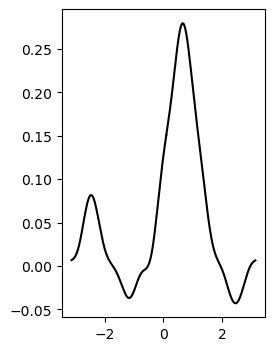

In [23]:
shift = np.pi+0.1
phi_special_here = np.zeros([2,points_num])
phi_special_here[0,:] = 0.5*np.ones([1,points_num])
phi_special_here[1,:] = np.linspace(-np.pi, np.pi, points_num)
phi_special_here[1,:] = phi_special_here[1,:] + shift
#print(phi_special[1,:])

indices = np.where(phi_special_here[1,:] > np.pi)
phi_special_here[:,phi_special_here[1,:] > np.pi] = phi_special_here[:,phi_special_here[1,:] > np.pi] - 2*np.pi
if np.size(indices) > 0:
    break_point = indices[0]
    break_point = break_point[0]
#print(phi_special[1,:])

indices = np.where(phi_special_here[1,:] < -np.pi)
phi_special_here[:,phi_special_here[1,:] < -np.pi] = phi_special_here[:,phi_special_here[1,:] < -np.pi] + 2*np.pi
if np.size(indices) > 0:
    break_point = indices[0]
    break_point = break_point[-1]
#print(phi_special[1,:])

fig = plt.figure(figsize = (12,4))

plt.subplot(1,4,3)
plt.plot(phi_special_here[1,:break_point], V_spec[neuron,:break_point],'k')
plt.plot(phi_special_here[1,break_point+1:], V_spec[neuron,break_point+1:],'k')
xyz_spec_rot_here = 1.1*xyz_spec_rot[0,:,:]

ax = fig.add_subplot('142', projection='3d')
#ax.view_init(elev=50, azim=400) #Works!
ax.scatter(xyz[0,:], xyz[1,:], xyz[2,:], c = V[neuron,:], marker='o', s = 10)
#ax.scatter(xyz_spec_rot_here[0,:], xyz_spec_rot_here[1,:], xyz_spec_rot_here[2,:], c='r',marker='o', s = 30)
ax.view_init(elev=45, azim=230) #Works!

vec_1_in_plane = xyz_spec_rot_here[:,0] - xyz_spec_rot_here[:,500]
vec_2_in_plane = xyz_spec_rot_here[:,0] - xyz_spec_rot_here[:,200]
normal_vector = np.cross(vec_1_in_plane, vec_2_in_plane)
unit_normal_vector = normal_vector/np.linalg.norm(normal_vector)
d = np.dot(xyz_spec_rot_here[:,0], unit_normal_vector)

#d = -point_1.dot(normal)
xx, yy = np.meshgrid(np.linspace(-1,1), np.linspace(-1,1))

ax = fig.add_subplot('141', projection='3d')
ax.view_init(elev=45, azim=230) #Works!
break_1 = 250
break_2 = 800
ax.scatter(xyz_spec_rot_here[0,break_1:break_2], xyz_spec_rot_here[1,break_1:break_2], xyz_spec_rot_here[2,break_1:break_2], c='r',marker='o', s = 30, zorder=1)
z = -1*(unit_normal_vector[0] * xx + unit_normal_vector[1] * yy - d) * 1. /unit_normal_vector[2]

#ax.scatter(xx, yy, z, alpha=1, color='r', zorder = -1)
ax.scatter(xyz[0,:], xyz[1,:], xyz[2,:], c = np.power(nn.relu(V[neuron,:]),1), marker='o', s = 10,zorder = 1, alpha = 0.01)

#ax.scatter(xyz_spec_rot_here[0,:], xyz_spec_rot_here[1,:], xyz_spec_rot_here[2,:], c='r',marker='o', s = 50)
#ax.view_init(elev=20, azim=100) #Works!
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlim(-1,1)

plt.subplot(1,4,4)
plt.scatter(phi[0,:], phi[1,:], c = V[neuron,:],s=20)
plt.plot(phi_spec[0,:],phi_spec[1,:],'.',c='r')


if to_save:
    plotters.saveFigure(fig, day, time, "Slice")

## In this part we will be looking at what happens if you stereoraphically project the sphere onto the plane, what responses do you get?

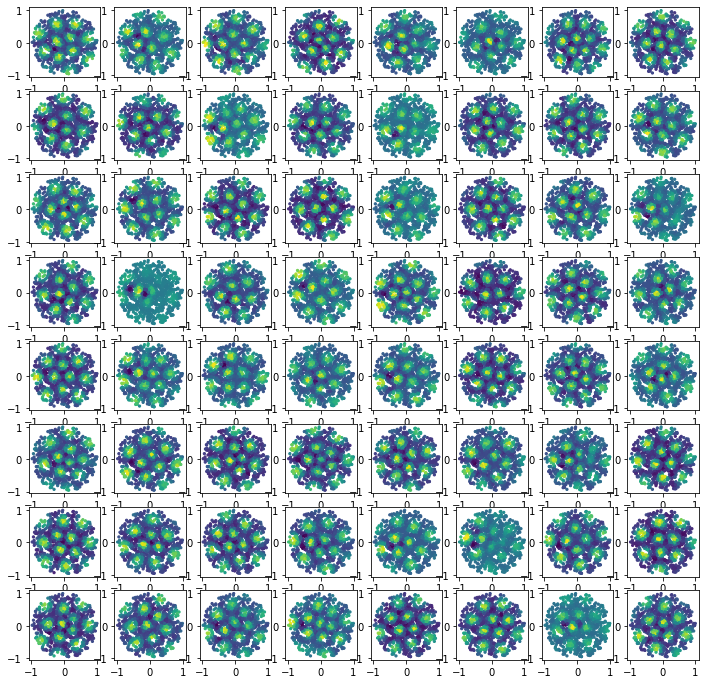

In [18]:
# First create a dataset 
xyz_here = xyz[:,xyz[2,:] < 0]
stereo_XY = np.zeros([2, xyz_here.shape[1]])
stereo_XY[0,:] = xyz_here[0,:]/(1 - xyz_here[2,:])
stereo_XY[1,:] = xyz_here[1,:]/(1 - xyz_here[2,:])


fig = plt.figure(figsize = (12,12))

for neuron in range(parameters["D"]):
    plt.subplot(8, 8, neuron+1)
    plt.scatter(stereo_XY[0,:], stereo_XY[1,:], c = V[neuron,xyz[2,:] < 0], s = 5)
    
if to_save:
    plotters.saveFigure(fig, day, time, "Stereo_Plot")

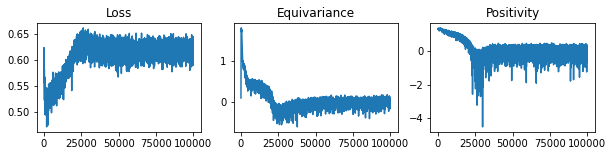

In [19]:
fig = plt.figure(figsize = (10,2))

#plt.plot(Losses[0,:], label='Combined Loss')
plt.subplot(1,3,1)
plt.plot(Losses[1,:])
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(Losses[2,:])
plt.title('Equivariance')
plt.subplot(1,3,3)
plt.plot(Losses[3,:])
plt.title('Positivity')

if to_save:
    plotters.saveFigure(fig, day, time, "Losses")